In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

from time import time

import multinet

import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

from PIL import Image
import cropset
import dataset

import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
net = multinet.pretrained("./model_multinet.pt")
backbone = net.features
# backbone.out_channels = net.classifier[1].in_features
backbone.out_channels = 20
num_classes = net.classifier[-1].out_features

anchor_generator = AnchorGenerator(
    sizes=((10,30,40,),), aspect_ratios=((1.,.5,),))
    
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'], output_size=15, sampling_ratio=1)

"""
image_mean (Tuple[float, float, float]): mean values used for input normalization.
  They are generally the mean values of the dataset on which the backbone has been trained
  on
image_std (Tuple[float, float, float]): std values used for input normalization.
  They are generally the std values of the dataset on which the backbone has been trained on
"""

# therefore should probably train features with z-score standardized data and provide mena and std into FasterRCNN
#  https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py#L61-L65

mean = (.4016, .3075, .2541)
std = (.3068, .2605, .2465)

model = FasterRCNN(
  backbone, num_classes=num_classes, image_mean=mean, image_std=std, min_size=800, max_size=800,
  rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)


# pretrained convnet features but classifier is not taken from pretrained model

net, model

loaded module has 5 classes


(MultiNet(
   (features): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=3920, out_features=2600, bias=True)
     (2): ReLU(inplace=True)
     (3): Linear(in_features=2600, out_features=1000, bias=True)
     (4): ReLU(inplace=True)
     (5): Linear(in_features=1000, out_features=5, bias=True)
   )
 ),
 FasterRCNN(
   (transform): GeneralizedRCNNTransform(
       Normalize(mean=(0.4016, 0.3075, 0.2541), std=(0.3068, 0.2605, 0.2465))
       Resize(min_size=(800,), max_size=800, mode='bilinear')
   )
   (backbone): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=

In [5]:
torch.__version__, torchvision.__version__

('1.10.0+cu113', '0.11.1+cu113')

In [6]:
dl = cropset.load(cropset.CropSet())
len(dl.dataset)

120

In [7]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=.005, momentum=0.9, weight_decay=0.0005)

model.to(device)

STEP = 2

mlosses, maccs = [], []
for epoch in range(300):
  r_loss, r_acc = 0., 0.
  s = time()
  for i, (img, l) in enumerate(dl):
    img, l = list(i.to(device) for i in img), [{k: v.to(device) for k, v in t.items()} for t in l]
    model.train()
    loss_dict = model(img, l)
    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    r_loss += losses
    r_acc += 0  # dunno
    
    log = False
    if (i+1) % STEP == 0:
      divisor = STEP
      log = True
    elif i+1 == len(dl):
      divisor = (i+1) % STEP
      log = True
    if log:
      mlosses.append(r_loss/divisor)
      maccs.append(r_acc/divisor)
      print(f"epoch:{epoch+1} loss:{mlosses[-1]:.4f} acc:{maccs[-1]:.2f} took:{time()-s:.2f}")
      s = time()
      r_loss, r_acc = 0., 0.


/home/spadge/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch:1 loss:2.4136 acc:0.00 took:0.77
epoch:1 loss:2.4256 acc:0.00 took:0.44
epoch:1 loss:2.3652 acc:0.00 took:0.44
epoch:1 loss:2.2955 acc:0.00 took:0.45
epoch:1 loss:2.2613 acc:0.00 took:0.45
epoch:1 loss:2.2171 acc:0.00 took:0.45
epoch:1 loss:2.1077 acc:0.00 took:0.47
epoch:1 loss:1.9997 acc:0.00 took:0.45
epoch:1 loss:1.7943 acc:0.00 took:0.46
epoch:1 loss:1.6817 acc:0.00 took:0.47
epoch:1 loss:1.4033 acc:0.00 took:0.45
epoch:1 loss:1.1900 acc:0.00 took:0.43
epoch:1 loss:1.0668 acc:0.00 took:0.45
epoch:1 loss:1.0405 acc:0.00 took:0.44
epoch:1 loss:0.9318 acc:0.00 took:0.44
epoch:2 loss:1.0673 acc:0.00 took:0.45
epoch:2 loss:1.0971 acc:0.00 took:0.45
epoch:2 loss:1.0182 acc:0.00 took:0.45
epoch:2 loss:1.0422 acc:0.00 took:0.45
epoch:2 loss:1.0488 acc:0.00 took:0.45
epoch:2 loss:1.0074 acc:0.00 took:0.45
epoch:2 loss:0.9612 acc:0.00 took:0.45
epoch:2 loss:0.9626 acc:0.00 took:0.45
epoch:2 loss:0.9691 acc:0.00 took:0.45
epoch:2 loss:0.8635 acc:0.00 took:0.44
epoch:2 loss:0.8931 acc:0

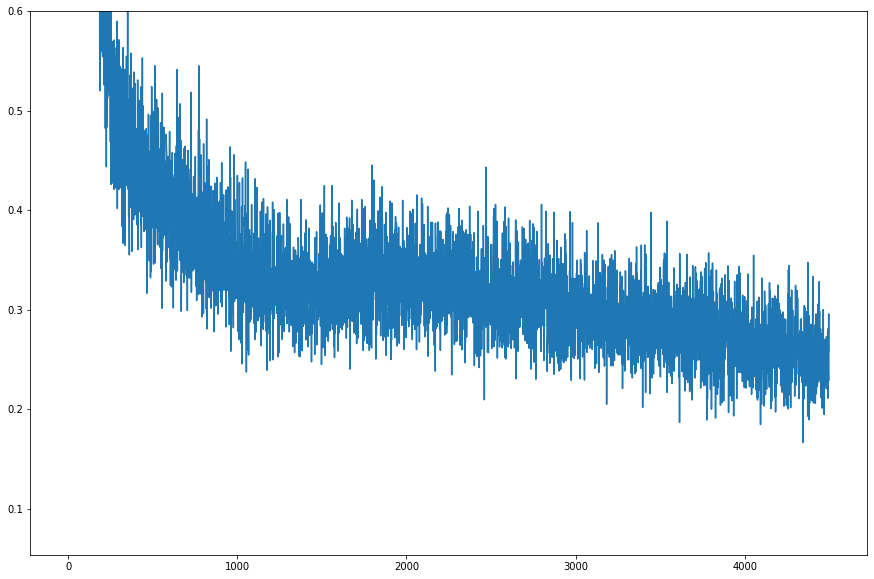

In [8]:
plt.figure(figsize=(15,10))
ax = plt.plot([i.detach().item() for i in mlosses])
plt.ylim(top=.6)
plt.show()


In [9]:
torch.save(model.state_dict(), "./ubernet.pt")

In [7]:
# model.load_state_dict(torch.load("./ubernet.pt"))

<All keys matched successfully>

torch.Size([3, 640, 800])
tensor([0.9997, 0.9996, 0.9993, 0.9984, 0.9944, 0.9929, 0.9863, 0.9481, 0.0518])
tensor([0.9997, 0.9996, 0.9993, 0.9984, 0.9944, 0.9929, 0.9863, 0.9481, 0.0518])
['worm', 'worm', 'worm', 'worm', 'dynamite', 'barrel', 'barrel', 'mine', 'barrel']


/home/spadge/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


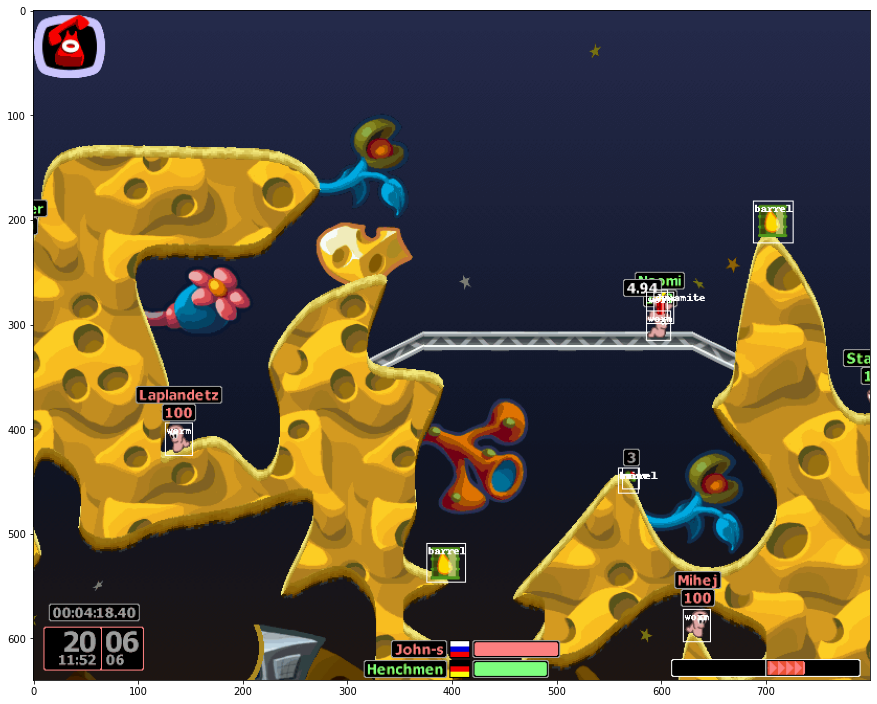

['bg', 'worm', 'mine', 'barrel', 'dynamite']

In [8]:
model.cpu()

with torch.no_grad():
#   mean, std = (.4016, .3075, .2541), (.3068, .2605, .2465)  # from feature trainset
  mean, std = (0.2945, 0.2550, 0.2586), (0.2492, 0.2100, 0.2303)  # from capture set
#   transform = Compose([ToTensor(), Normalize(mean=mean, std=std)])
  transform = Compose([ToTensor()])
  # img = transform(Image.open("./labelling/source/2378_0_22947.png").convert('RGB'))
  img = transform(Image.open("./labelling/source/1581_0_18063.png").convert('RGB'))
  print(img.shape)
  model.eval()
  y = model(img.unsqueeze(0))[0]
  print(y['scores'])

topk  = y['scores'] > .01
print(y['scores'][topk])
print([dataset.CLASSES[i] for i in y['labels'][topk]])
plt.figure(figsize=(15,15))
bb = draw_bounding_boxes(
  (img*255).to(torch.uint8), boxes=y['boxes'][topk], labels=[dataset.CLASSES[i] for i in y['labels'][topk]])
# bb = draw_bounding_boxes(
#   (img*255).to(torch.uint8), boxes=y['boxes'], labels=[dataset.CLASSES[i] for i in y['labels']])
plt.imshow(bb.permute(1,2,0))
plt.show()
dataset.CLASSES

In [11]:
models.detection.fasterrcnn_resnet50_fpn()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/spadge/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
models.mobilenet_v2()